# Bring Packages

In [1]:

import numpy as np
import sklearn
from imblearn.over_sampling import SMOTE
from collections import Counter
import matplotlib.pyplot as plt

# Load Data

In [3]:
# Load data
print("Loading training data...")
X_train = np.load("..Data//data_train.npy").astype(int)
print("Training data loaded.")
# shape: (num_documents, num_terms)
print("Loading training labels...")
y_train = np.loadtxt('..Data//label_train.csv',skiprows=1,delimiter=',').astype(int)  # shape: (num_documents,)
print("Training labels loaded.")
print("Loading test data...")
X_test = np.load("..Data//data_test.npy").astype(int)  # shape: (num_test_documents, num_terms)
print("Test data loaded.")
print("Loading vocabulary...")
vocab_data = np.load("..Data//vocab_map.npy", allow_pickle=True)
print("Vocab data loaded.")

# Check dimensions
print(f"Training data shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Vocab data shape: {vocab_data.shape}")



Loading training data...
Training data loaded.
Loading training labels...
Training labels loaded.
Loading test data...
Test data loaded.
Loading vocabulary...
Vocab data loaded.
Training data shape: (9422, 26354)
Training labels shape: (9422, 2)
Test data shape: (2356, 26354)
Vocab data shape: (26354,)


In [4]:
vocab_data.shape

(26354,)

In [5]:
x_raw = X_train
y_raw = y_train[:,1]

In [6]:
def testdf(df):
    if isinstance(df, pd.DataFrame):
        print("The object is a DataFrame.")
    else:
        print("The object is not a DataFrame.")

def test_if_list(obj):
    if isinstance(obj, list):
        print("The object is a list.")
    else:
        print("The object is not a list.")

def test_if_tuple(obj):
    if isinstance(obj, tuple):
        print("The object is a tuple.")
    else:
        print("The object is not a tuple.")

def test_if_array(obj):
    if isinstance(obj, np.ndarray):
        print("The object is a numpy array.")
    else:
        print("The object is not a numpy array.")

# Model

In [7]:
def compute_class_weights(y):
    classes, counts = np.unique(y, return_counts=True)
    total_samples = len(y)
    class_weights = {cls: total_samples / (len(classes) * count) for cls, count in zip(classes, counts)}
    return class_weights

def weighted_binary_cross_entropy(y_true, y_pred, class_weights):
    epsilon = 1e-15  # To avoid log(0)
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    weights = np.vectorize(class_weights.get)(y_true)
    loss = -np.mean(weights * (y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred)))
    return loss

In [8]:
class GaussianMaxLikelihood:
    def __init__(self, n_dims):
        self.n_dims = n_dims
        self.mu = np.zeros(n_dims)
        # We only save a scalar standard deviation because our model is the isotropic Gaussian
        self.sigma_sq = 1.0

    # For a training set, the function should compute the ML estimator of the mean and the variance
    def train(self, train_data,weights = None):
        # Here, you have to find the mean and variance of the train_data data and put it in self.mu and self.sigma_sq
        ### Using the expressions derived above
        if weights is None:
            weights = np.ones(train_data.shape[0])
        self.mu = np.average(train_data, axis=0, weights=weights)
        self.sigma_sq = np.average((train_data - self.mu) ** 2.0, axis=0, weights=weights).mean()


    # Returns a vector of size nb. of test ex. containing the log probabilities of each test example under the model.
    # exemple test
    def loglikelihood(self, test_data):
        ### a is the log of the first term (1/(sigma sqrt(2pi))) in the isotropic probability distribution in the image above
        ### We are using log(ab) = log(a)+log(b) where a is 1/(sigma sqrt(2pi)) and b is exp(-||x-mu||^2/(2*sigma^2)). Again see the image above.
        a = self.n_dims * -(np.log(np.sqrt(self.sigma_sq)) + (1 / 2) * np.log(2 * np.pi))
        log_prob = a - np.sum((test_data - self.mu) ** 2.0, axis=1) / (2.0 * self.sigma_sq)
        return log_prob


In [9]:
class BayesClassifier:
    def __init__(self, maximum_likelihood_models, priors):
        self.maximum_likelihood_models = maximum_likelihood_models ### a list of multi-variate MaxLikelihoodGaussians for each class
        self.priors = priors
        if len(self.maximum_likelihood_models) != len(self.priors):
            print('The number of ML models must be equal to the number of priors!')
        self.n_classes = len(self.maximum_likelihood_models)

    # Returns a matrix of size number of test ex. times number of classes containing the log
    # probabilities of each test example under each model, trained by ML.
    def loglikelihood(self, test_data):

        log_pred = np.zeros((test_data.shape[0], self.n_classes))

        for i in range(self.n_classes):
            # Here, we will have to use maximum_likelihood_models[i] and priors to fill in for each class
            # each column of log_pred (it's more efficient to do a entire column at a time)
            log_pred[:, i] = self.maximum_likelihood_models[i].loglikelihood(test_data) + np.log(self.priors[i])

        return log_pred

In [10]:
print(y_train)
print(y_raw)

[[   0    0]
 [   1    0]
 [   2    0]
 ...
 [9419    0]
 [9420    0]
 [9421    0]]
[0 0 0 ... 0 0 0]


# Data Cleaning

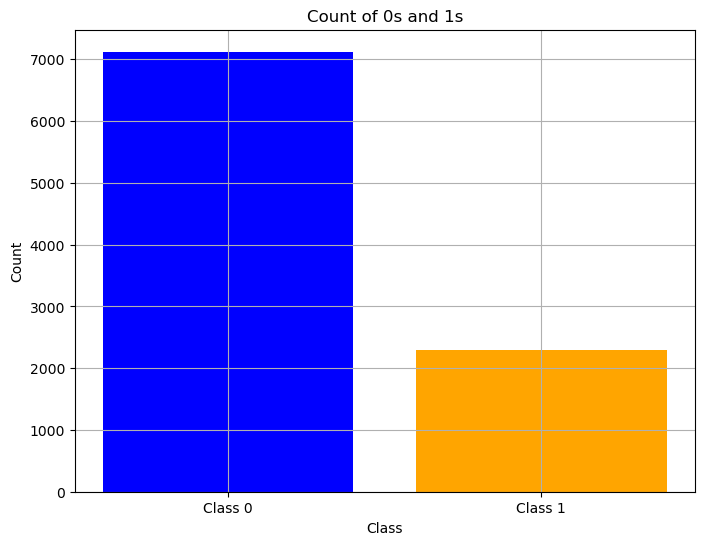

In [11]:
# Extract the class labels from the second column of y_train
class_labels = y_raw

# Count the occurrences of class 0 and class 1
unique, counts = np.unique(class_labels, return_counts=True)
count_dict = dict(zip(unique, counts))

# Create a bar chart
plt.figure(figsize=(8, 6))
plt.bar(count_dict.keys(), count_dict.values(), color=['blue', 'orange'])
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Count of 0s and 1s')
plt.xticks([0, 1], ['Class 0', 'Class 1'])
plt.grid(True)
plt.show()

In [12]:
# Calculate the difference and ratio of counts
count_diff = abs(count_dict[0] - count_dict[1])
count_ratio = count_dict[0] / count_dict[1] if count_dict[1] != 0 else float('inf')

# Print the results
print(f"Difference in counts: {count_diff}")
print(f"Ratio of counts: {count_ratio:.2f}")

Difference in counts: 4826
Ratio of counts: 3.10


In [13]:
def print_class_percentages(y, dataset_name):
    unique, counts = np.unique(y, return_counts=True)
    total = len(y)
    percentages = {cls: (count / total) * 100 for cls, count in zip(unique, counts)}
    
    print(f"Class percentages for {dataset_name}:")
    for cls, percentage in percentages.items():
        print(f"Class {cls}: {percentage:.2f}%")

# Print class percentages for training and test datasets
print_class_percentages(class_labels, "Training Dataset")


Class percentages for Training Dataset:
Class 0: 75.61%
Class 1: 24.39%


In [14]:
print(unique, counts)

[0 1] [7124 2298]


## See on average how often does a word appear in text

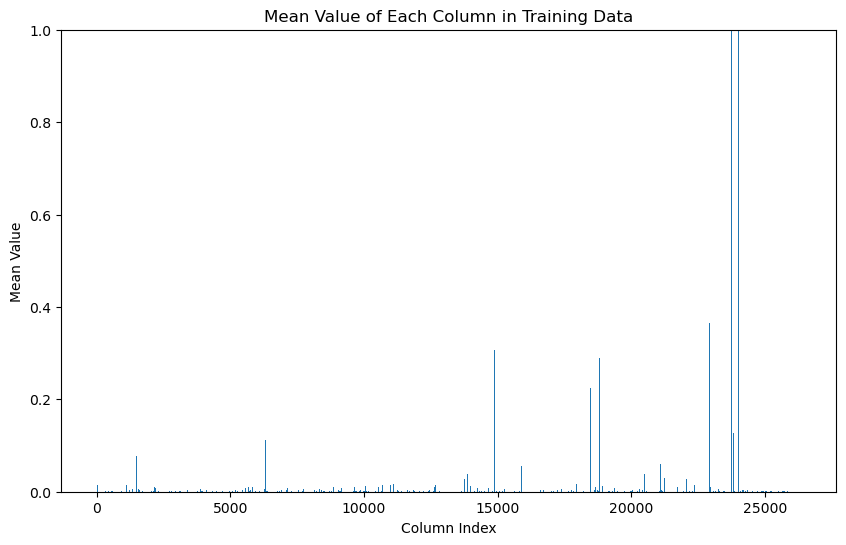

In [15]:
column_means = np.mean(X_train, axis=0)
# Plot the mean values
plt.figure(figsize=(10, 6))
plt.bar(range(len(column_means)), column_means)
plt.xlabel('Column Index')
plt.ylabel('Mean Value')
plt.ylim(0, 1)
plt.title('Mean Value of Each Column in Training Data')
plt.show()

In [16]:
# Calculate the mean of each column
column_means = np.mean(X_train, axis=0)

# Calculate the frequency of non-zero values in each column
non_zero_frequencies = np.count_nonzero(X_train, axis=0) / X_train.shape[0]

# Define the criteria
mean_threshold = 0.1
frequency_threshold = 0.1

# Filter columns based on the criteria
columns_to_keep = (column_means >= mean_threshold) & (non_zero_frequencies >= frequency_threshold)
X_train_filtered = X_train[:, columns_to_keep]

print(columns_to_keep)

[False False False ... False False False]


In [17]:
vocab_data[columns_to_keep]

array(['accuracy', 'algorithm', 'algorithms', 'all', 'also', 'an',
       'analysis', 'and', 'applications', 'approach', 'approaches', 'are',
       'art', 'as', 'at', 'based', 'be', 'been', 'better', 'between',
       'both', 'but', 'by', 'can', 'classification', 'data', 'datasets',
       'deep', 'demonstrate', 'different', 'each', 'efficient',
       'existing', 'experiments', 'features', 'first', 'for', 'framework',
       'from', 'given', 'has', 'have', 'high', 'how', 'however', 'in',
       'information', 'into', 'is', 'it', 'its', 'knowledge', 'language',
       'large', 'learning', 'machine', 'many', 'method', 'methods',
       'model', 'models', 'more', 'most', 'network', 'networks', 'neural',
       'new', 'non', 'not', 'novel', 'number', 'of', 'on', 'one', 'only',
       'or', 'order', 'other', 'our', 'over', 'paper', 'performance',
       'present', 'problem', 'problems', 'propose', 'proposed', 'provide',
       'real', 'results', 'set', 'several', 'show', 'some', 'state',


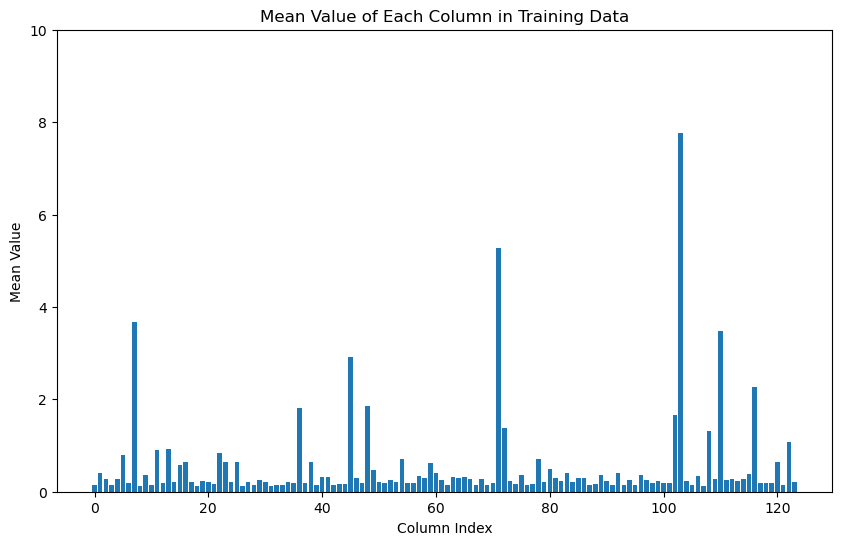

In [18]:
column_means = np.mean(X_train_filtered, axis=0)
# Plot the mean values
plt.figure(figsize=(10, 6))
plt.bar(range(len(column_means)), column_means)
plt.xlabel('Column Index')
plt.ylabel('Mean Value')
plt.ylim(0, 10)
plt.title('Mean Value of Each Column in Training Data')
plt.show()

In [19]:
ind_class0 = (y_train[:,1]==1).nonzero()[0]
print(ind_class0)
ind_class1 = (y_train[:,1]==0).nonzero()[0]
print(ind_class1)

[   4    8    9 ... 9410 9412 9418]
[   0    1    2 ... 9419 9420 9421]


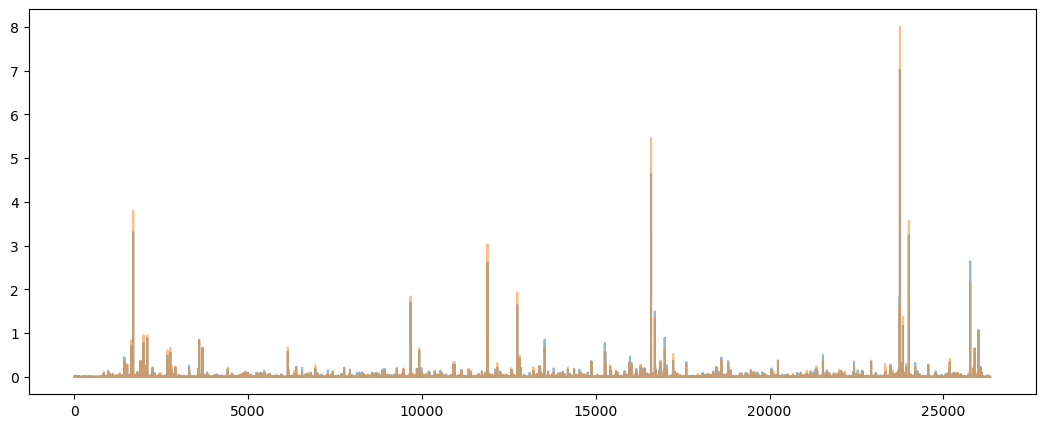

In [20]:
plt.figure(figsize=(13,5))
plt.plot(X_train[ind_class0,:].mean(axis=0),alpha=0.5)
plt.plot(X_train[ind_class1,:].mean(axis=0),alpha=0.5)
# plt.semilogy()
# plt.ylim(0.1,2)

# Increase under represented class 1 using SMOTE

In [21]:
def smote(X, y, minority_class, N):
    """
    Synthetic Minority Over-sampling Technique (SMOTE) implementation using numpy.
    
    Parameters:
    - X: Feature matrix
    - y: Labels
    - minority_class: The class to be oversampled
    - N: Number of synthetic samples to generate
    
    Returns:
    - X_resampled: Feature matrix after SMOTE
    - y_resampled: Labels after SMOTE
    """
    # Extract minority class samples
    X_minority = X[y == minority_class]
    
    # Number of minority samples
    n_minority_samples = X_minority.shape[0]
    
    # Number of features
    n_features = X_minority.shape[1]
    
    # Initialize synthetic samples array
    synthetic_samples = np.zeros((N, n_features))
    
    for i in range(N):
        # Randomly choose two minority samples
        idx1, idx2 = np.random.choice(n_minority_samples, 2, replace=False)
        sample1, sample2 = X_minority[idx1], X_minority[idx2]
        
        # Generate a synthetic sample
        diff = sample2 - sample1
        gap = np.random.rand()
        synthetic_sample = sample1 + gap * diff
        
        # Ensure the synthetic sample is integer
        synthetic_samples[i] = np.round(synthetic_sample).astype(int)
    
    # Combine original data with synthetic samples
    X_resampled = np.vstack((X, synthetic_samples))
    y_resampled = np.hstack((y, np.full(N, minority_class)))
    
    return X_resampled, y_resampled

In [22]:
minority_class = 1  # Replace with your minority class label



N = 4826  # Number of synthetic samples to generate (difference in class 0 and class 1 data)
X_resampled, y_resampled = smote(x_raw, y_raw, minority_class, N)

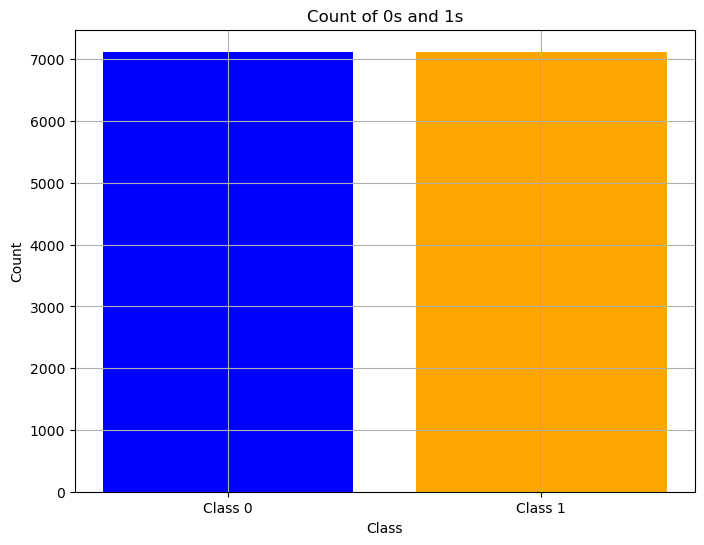

In [23]:
# Extract the class labels from the second column of y_train
class_labels = y_resampled

# Count the occurrences of class 0 and class 1
unique, counts = np.unique(class_labels, return_counts=True)
count_dict = dict(zip(unique, counts))

# Create a bar chart
plt.figure(figsize=(8, 6))
plt.bar(count_dict.keys(), count_dict.values(), color=['blue', 'orange'])
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Count of 0s and 1s')
plt.xticks([0, 1], ['Class 0', 'Class 1'])
plt.grid(True)
plt.show()

## Identify the means of appearance of words when class 1 vs when class 0 and finding the words with the largest difference of appearances

In [24]:
X_train = X_resampled
y_train = y_resampled

In [25]:
# Calculate the mean appearance of each word for each class
mean_appearance_class_0 = X_train[y_train == 0].mean(axis=0)
mean_appearance_class_1 = X_train[y_train == 1].mean(axis=0)

# Compute the absolute difference in mean appearance between the two classes
mean_difference = np.abs(mean_appearance_class_0 - mean_appearance_class_1)

# Identify the words with the largest differences
largest_diff_indices = np.argsort(mean_difference)[::-1]  # Sort indices in descending order of difference

top_n = 30  # Number of top words to display
top_words = [vocab_data[i] for i in largest_diff_indices[:top_n]]
print(top_words)


['the', 'of', 'we', 'and', 'in', 'to', 'is', 'our', 'models', 'that', 'this', 'model', 'learning', 'system', 'neural', 'are', 'paper', 'on', 'for', 'based', 'systems', 'used', 'show', 'matrix', 'an', 'art', 'tasks', 'be', 'convex', 'state']


In [26]:
mean_difference

array([0.00028074, 0.00407075, 0.00014037, ..., 0.00028074, 0.00028074,
       0.00210556])

In [27]:
#Remove the useless data
# Calculate the mean of each column
column_means = X_train.mean(axis=0)

# Identify columns where the mean is zero
columns_to_drop = np.where(column_means == 0)[0]

# Drop these columns from the dataset
X_train_zero_dropped = np.delete(X_train, columns_to_drop, axis=1)



In [28]:
#log transform the data

x_log = np.log(X_train_zero_dropped+1)

In [29]:
x_raw.shape

(9422, 26354)

In [30]:
y_raw.shape

(9422,)

In [31]:
len(column_means)

26354

In [32]:
column_means = np.mean(x_log, axis=0)
means = np.mean(x_log, axis=1)
std = column_means.std()
means


array([0.00206832, 0.00306722, 0.00169472, ..., 0.00339478, 0.00288074,
       0.00417394])

In [33]:
np.mean(column_means)

0.002888312271943901

In [34]:
np.std(column_means)

0.028982138500157066

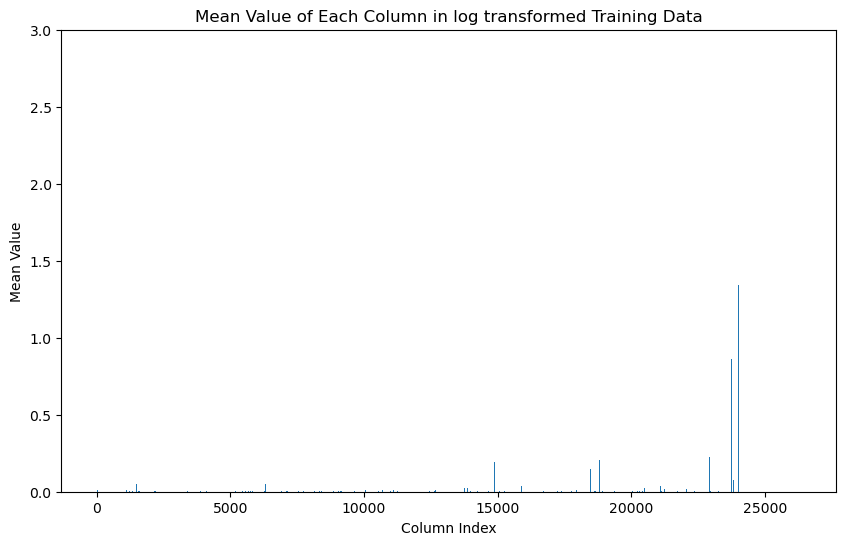

In [35]:
column_means = np.mean(x_log, axis=0)
# Plot the mean values
plt.figure(figsize=(10, 6))
plt.bar(range(len(column_means)), column_means)
plt.xlabel('Column Index')
plt.ylabel('Mean Value')
plt.ylim(0, 3)
plt.title('Mean Value of Each Column in log transformed Training Data')
plt.show()

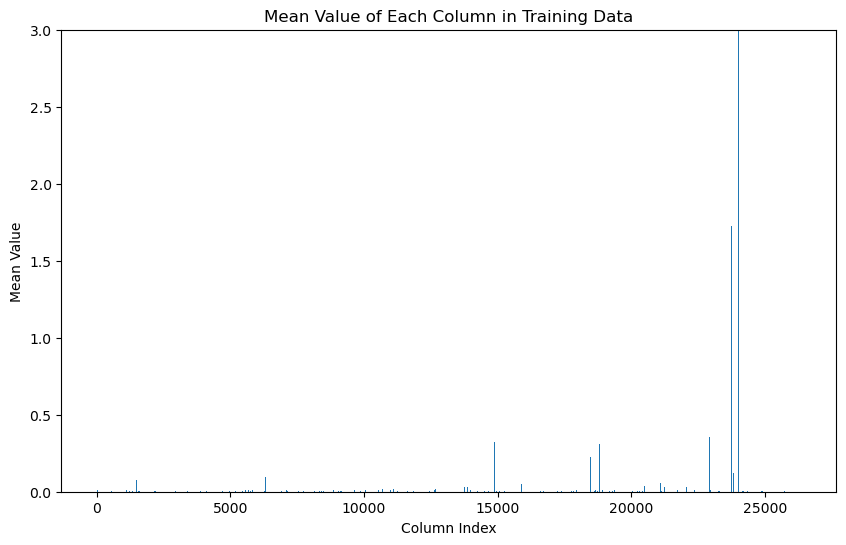

In [36]:
column_means = np.mean(X_train_zero_dropped, axis=0)
# Plot the mean values
plt.figure(figsize=(10, 6))
plt.bar(range(len(column_means)), column_means)
plt.xlabel('Column Index')
plt.ylabel('Mean Value')
plt.ylim(0, 3)
plt.title('Mean Value of Each Column in Training Data')
plt.show()

In [37]:
def remove_columns_by_mean(X, threshold):
    """
    Remove columns based on the mean of the column values.
    
    Parameters:
    - X: Feature matrix
    - threshold: Mean value threshold for removing columns
    
    Returns:
    - X_filtered: Feature matrix with specified columns removed
    """
    # Calculate column mean and standard deviation for column means
    column_means = np.mean(X, axis=0)
    means = np.mean(column_means)
    stds = np.std(column_means)

    print(means)
    print(stds)
    # Identify outliers
    lower_bound = means - threshold * stds
    upper_bound = means + threshold * stds
    
    # Create a mask for rows without outliers
    mask = np.where((column_means >= lower_bound) & (column_means <= upper_bound))[0]
    

    return mask

In [38]:
    # Filter out rows with outliers
mask = remove_columns_by_mean(x_raw,1)   
x_wo_outliers =  x_raw[:, mask]

0.00519666776890263
0.07702163385032289


In [39]:
print(x_wo_outliers.shape)
print(x_raw.shape)

(9422, 26149)
(9422, 26354)


In [40]:
column_means = np.mean(x_wo_outliers, axis=0)
print(column_means)

[0.00021227 0.00870304 0.00010613 ... 0.00021227 0.00021227 0.00159202]


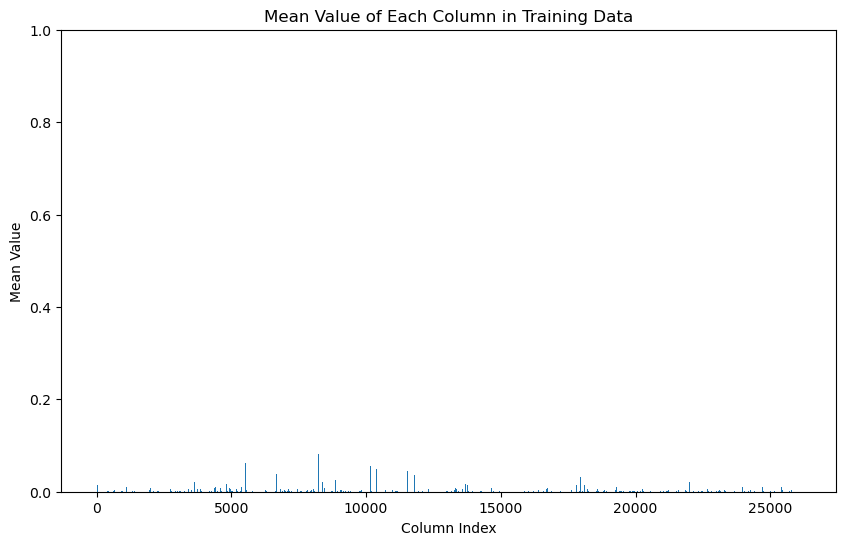

In [41]:
column_means = np.mean(x_wo_outliers, axis=0)
# Plot the mean values
plt.figure(figsize=(10, 6))
plt.bar(range(len(column_means)), column_means)
plt.xlabel('Column Index')
plt.ylabel('Mean Value')
plt.ylim(0, 1)
plt.title('Mean Value of Each Column in Training Data')
plt.show()

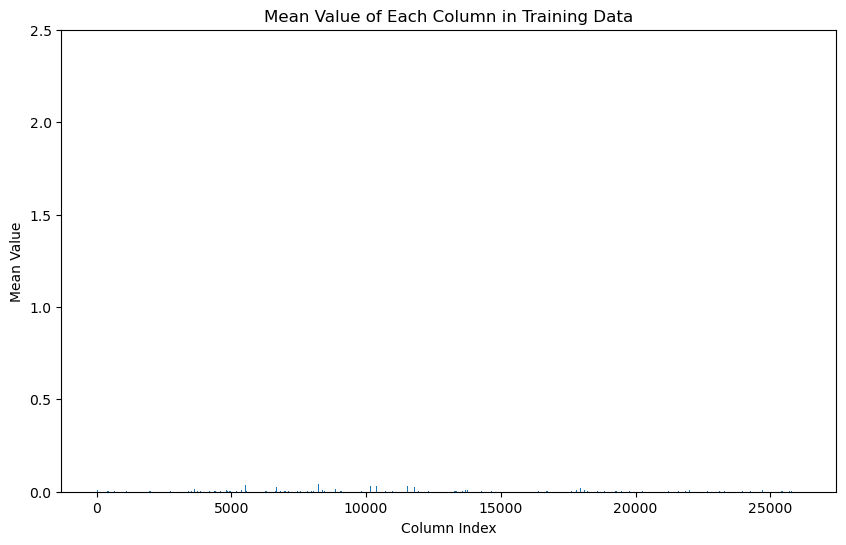

In [42]:
x_log = np.log(1+x_wo_outliers)
column_means = np.mean(x_log, axis=0)
# Plot the mean values
plt.figure(figsize=(10, 6))
plt.bar(range(len(column_means)), column_means)
plt.xlabel('Column Index')
plt.ylabel('Mean Value')
plt.ylim(0, 2.5)
plt.title('Mean Value of Each Column in Training Data')
plt.show()

In [43]:
def remove_low_variance_features(X, threshold=0.01):
    """
    Remove low-variance features from the dataset.
    
    Parameters:
    - X: Feature matrix
    - threshold: Variance threshold for removing features
    
    Returns:
    - X_filtered: Feature matrix with low-variance features removed
    """
    # Calculate the variance of each column
    column_variances = np.var(X, axis=0)
    
    # Identify columns where the variance is above the threshold
    columns_to_keep = np.where(column_variances > threshold)[0]
    
    # Keep only the columns that meet the criteria
    X_filtered = X[:, columns_to_keep]
    
    return X_filtered

# Example usage
# Assuming X_train is your feature matrix and you want to remove columns with variance <= 0.01
threshold = 0.01
X_train_filtered = remove_low_variance_features(x_raw, threshold)

print(X_train_filtered)
print(X_train_filtered.shape)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(9422, 2434)


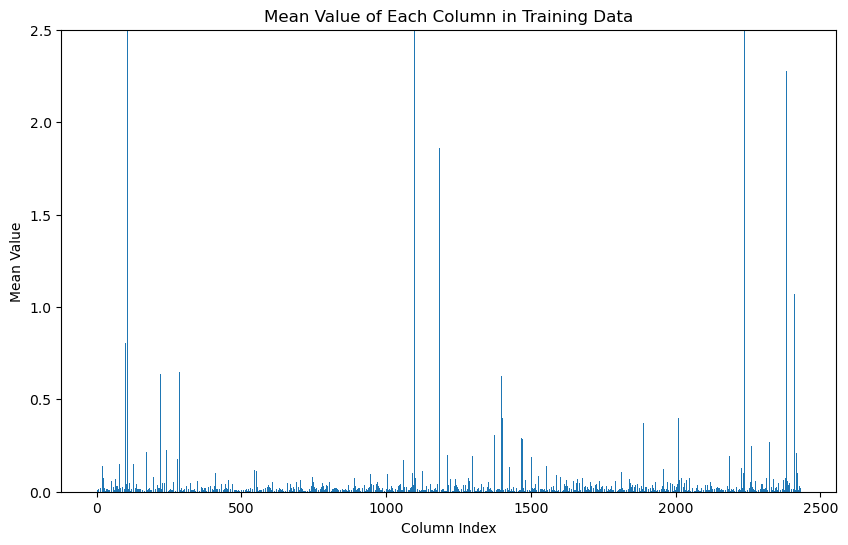

In [44]:
column_means = np.mean(X_train_filtered, axis=0)
# Plot the mean values
plt.figure(figsize=(10, 6))
plt.bar(range(len(column_means)), column_means)
plt.xlabel('Column Index')
plt.ylabel('Mean Value')
plt.ylim(0, 2.5)
plt.title('Mean Value of Each Column in Training Data')
plt.show()

In [45]:
def clip_outliers(X, threshold):
    """
    Clip outliers in the dataset to a specified threshold.
    
    Parameters:
    - X: Feature matrix
    - threshold: Value threshold for clipping
    
    Returns:
    - X_clipped: Feature matrix with outliers clipped
    """
    # Clip values in the dataset to the specified threshold
    X_clipped = np.clip(X, None, threshold)
    
    return X_clipped

# Example usage
# Assuming X_train is your feature matrix and you want to clip values above 100
threshold = 1
X_train_clipped = clip_outliers(X_train, threshold)

print(X_train_clipped)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


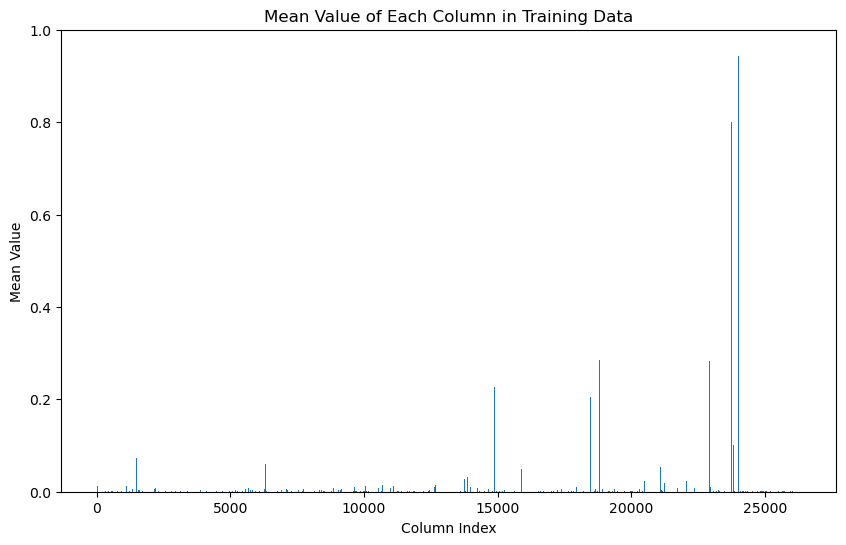

In [46]:
column_means = np.mean(X_train_clipped, axis=0)
# Plot the mean values
plt.figure(figsize=(10, 6))
plt.bar(range(len(column_means)), column_means)
plt.xlabel('Column Index')
plt.ylabel('Mean Value')
plt.ylim(0, 1)
plt.title('Mean Value of Each Column in Training Data')
plt.show()

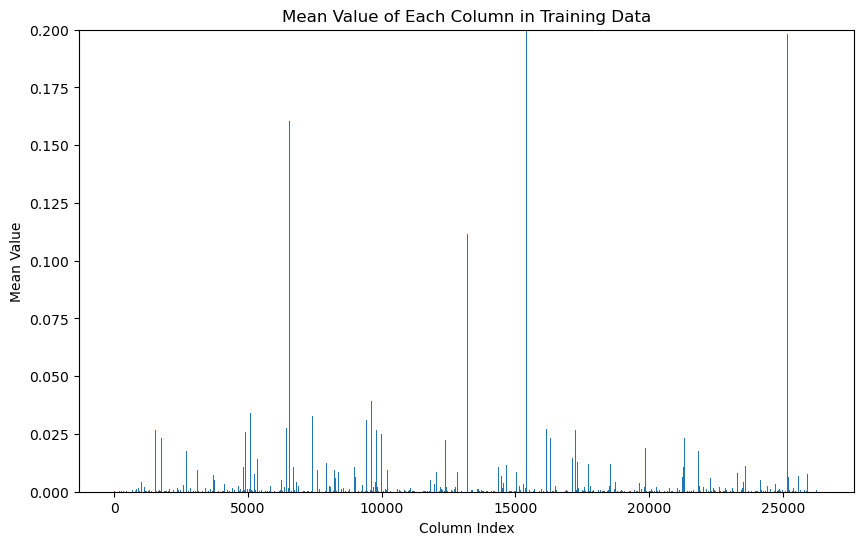

In [47]:
column_means = np.mean(X_train_clipped, axis=0)
# Plot the mean values
plt.figure(figsize=(10, 6))
plt.bar(range(len(column_means)), column_means)
plt.xlabel('Column Index')
plt.ylabel('Mean Value')
plt.ylim(0, 0.2)
plt.title('Mean Value of Each Column in Training Data')
plt.show()

## Stop words removal

In [48]:
# Define a list of stop words
stop_words = ['a', 'an', 'the', 'and', 'or', 'but', 'if', 'while', 'with', 'without', 'of', 'at', 'by', 'for', 'to', 'in', 'on', 'from', 'up', 'down', 'out', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now']

# Identify the indices of the stop words in the vocabulary
stop_word_indices = [i for i, word in enumerate(vocab_data) if word in stop_words]

print(stop_word_indices)

[1293, 1466, 1634, 1691, 1811, 2246, 3299, 3571, 3590, 3686, 7452, 7487, 7761, 9341, 9674, 9921, 10008, 11072, 11341, 11639, 11884, 13002, 15415, 15442, 16141, 16262, 16291, 16335, 16591, 16701, 16703, 16717, 16865, 16972, 16991, 17049, 17136, 20791, 21536, 21929, 22003, 22924, 23744, 23753, 23774, 23796, 24009, 24051, 24780, 25114, 25415, 25891, 25894, 25911, 25926, 25974, 26016, 26021]


## Selecting how many variables to include in the ML

In [49]:
top_n = 50

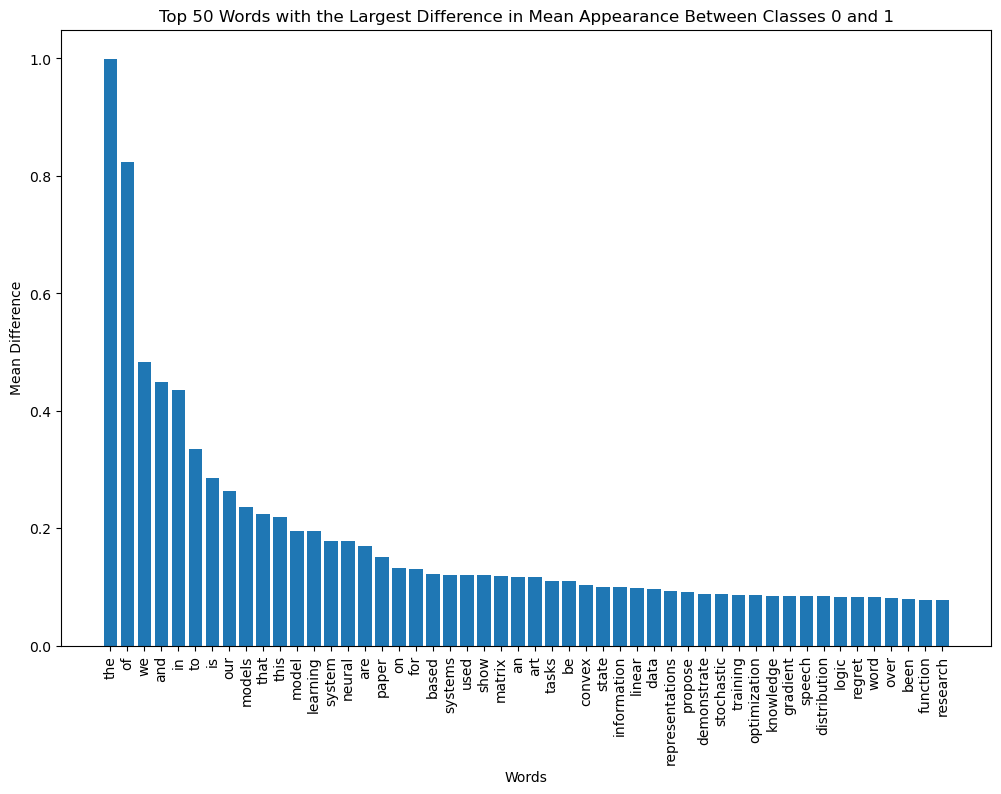

In [50]:
# Sort the mean differences and get the corresponding words
sorted_indices = np.argsort(mean_difference)[::-1]  # Sort in descending order
sorted_mean_difference = mean_difference[sorted_indices]
sorted_words = [vocab_data[i] for i in sorted_indices]



# Plot the histogram
plt.figure(figsize=(12, 8))
plt.bar(sorted_words[:top_n], sorted_mean_difference[:top_n])  # Plot top 20 words
plt.xlabel('Words')
plt.ylabel('Mean Difference')
plt.title(f'Top {top_n} Words with the Largest Difference in Mean Appearance Between Classes 0 and 1')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()

In [51]:
top_n_indices = np.argsort(mean_difference)[-top_n:]  # Get the top n indices

# Filter X_train to only include the columns of the top n differences
X_train_filtered = X_train[:, top_n_indices]


In [52]:
print(y_train)

[0 0 0 ... 1 1 1]


# Train


# Evaluate the model for different numbers of top words

## F1 Score

In [53]:
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import f1_score, precision_score, recall_score


In [54]:
def get_mean_difference(topn,x,y):
    # Calculate the mean appearance of each word for each class
    mean_appearance_class_0 = x[y == 0].mean(axis=0)
    mean_appearance_class_1 = x[y == 1].mean(axis=0)
    
    # Compute the absolute difference in mean appearance between the two classes
    mean_difference = np.abs(mean_appearance_class_0 - mean_appearance_class_1)
  

    return mean_difference



In [55]:
def precision_recall(y_pred, y_true):
    """
    Calculate precision and recall using only NumPy.
    
    Parameters:
    - y_pred: Predicted labels
    - y_true: True labels
    
    Returns:
    - precision: Precision score
    - recall: Recall score
    """
    # Convert to NumPy arrays
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    
    # Calculate True Positives (TP), False Positives (FP), and False Negatives (FN)
    TP = np.sum((y_pred == 1) & (y_true == 1))
    FP = np.sum((y_pred == 1) & (y_true == 0))
    FN = np.sum((y_pred == 0) & (y_true == 1))
    
    # Calculate precision and recall
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (FN + TP) if (FN + TP) > 0 else 0
    
    return precision, recall


In [56]:
def f1_score(precision,recall):
    f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return f1_score

In [57]:
def topn_get_F1_score(top_n, mean_difference, X_train, y_train):
    """
    Calculate F1 score for top N features.
    
    Parameters:
    - top_n: Number of top features to select
    - mean_difference: Array of mean differences for feature selection
    - X_train: Training feature matrix
    - y_train: Training labels
    
    Returns:
    - train_f1_score: F1 score for training data
    - val_f1_score: F1 score for validation data
    """
    # Filter the data
    top_n_indices = np.argsort(mean_difference)[-top_n:]  # Get the top n indices
    x_train_filtered = X_train[:, top_n_indices]

    import random
    random.seed(3395)
    # Randomly choose indexes for the train and val dataset, say with 80-20 split
    num_data = x_train_filtered.shape[0]
    inds = list(range(num_data))
    random.shuffle(inds)
    train_inds = inds[:int(0.8 * num_data)]
    val_inds = inds[int(0.8 * num_data):]
    
    # Split the data into train and val sets
    train_data = x_train_filtered[train_inds, :]
    train_labels = y_train[train_inds]
    val_data = x_train_filtered[val_inds, :]
    val_labels = y_train[val_inds]
        
    iris_train1 = train_data[train_labels == 0, :]
    iris_train2 = train_data[train_labels == 1, :]
    
    # We create a model per class (using maximum likelihood)
    model_class1 = GaussianMaxLikelihood(top_n)
    model_class2 = GaussianMaxLikelihood(top_n)
    
    # We train each of them using the corresponding data
    model_class1.train(iris_train1)
    model_class2.train(iris_train2)
    
    # We create a list of all our models, and the list of prior values
    total_num = len(iris_train1) + len(iris_train2)
    priors = [len(iris_train1) / total_num, len(iris_train2) / total_num]
    
    # We create our classifier with our list of Gaussian models and our priors
    classifier = BayesClassifier([model_class1, model_class2], priors)
    
    # Calculate the log-probabilities according to our model
    log_prob = classifier.loglikelihood(train_data)
    # Predict labels
    train_classes_pred = log_prob.argmax(1)
    train_precision, train_recall = precision_recall(train_classes_pred, train_labels)
    train_f1_score = f1_score(train_precision, train_recall)

    # Calculate the log-probabilities according to our model
    log_prob = classifier.loglikelihood(val_data)
    # Predict labels
    val_classes_pred = log_prob.argmax(1)
    val_precision, val_recall = precision_recall(val_classes_pred, val_labels)
    val_f1_score = f1_score(val_precision, val_recall)
    
    return train_f1_score, val_f1_score

In [58]:
X_train.shape

(14248, 26354)

## Call Data

## Smote resampled Data

In [59]:
x = X_resampled
y = y_resampled

In [60]:
mask = remove_columns_by_mean(x, 3)
combined_mask = [col for col in mask if col not in stop_word_indices]
mask.shape

0.00511394134548752
0.07506530202151103


(26293,)

In [61]:
x = np.log(1+x)

In [62]:
x= x[:, mask]

In [63]:
x.shape

(14248, 26293)

In [64]:
# Evaluate the model for different numbers of top words
max_n = 1001
top_ns = range(750, max_n,10)  # Evaluate for top 10, 20, ..., 100 words
mean_diff = get_mean_difference(max_n,x,y)



In [65]:
topn_get_F1_score(160,mean_diff,x,y)

(0.6473358574198911, 0.6506199854121079)

In [66]:
train_f1_scores = []
val_f1_scores = []
for top_n in top_ns:
    train_f1, val_f1 = topn_get_F1_score(top_n,mean_diff,x,y)
    train_f1_scores.append(train_f1)
    val_f1_scores.append(val_f1)


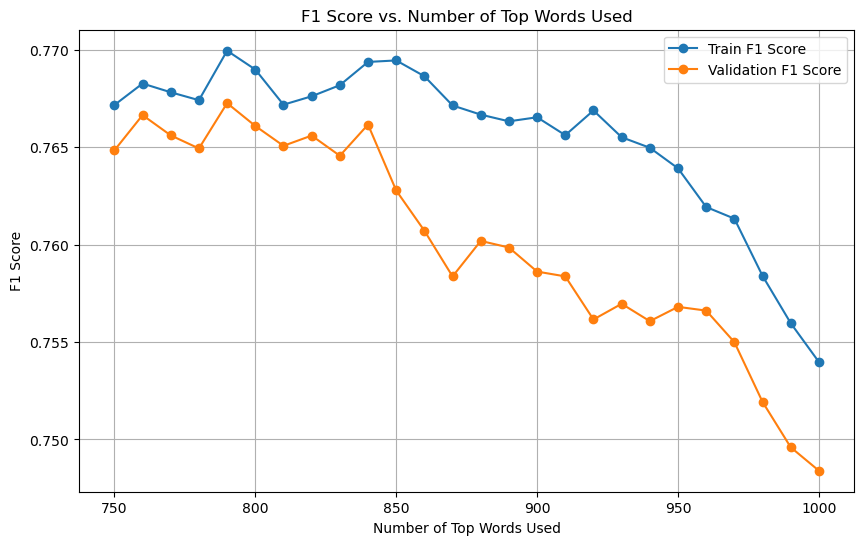

In [67]:


# Plot the F1 score against the number of top words used
plt.figure(figsize=(10, 6))
plt.plot(top_ns, train_f1_scores, marker='o', label='Train F1 Score')
plt.plot(top_ns, val_f1_scores, marker='o', label='Validation F1 Score')
plt.xlabel('Number of Top Words Used')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Number of Top Words Used')
plt.legend()
plt.grid(True)
plt.show()

In [68]:
# Assuming topn_get_F1_score, mean_diff, x, y, and top_ns are defined
del max


# Find the maximum validation F1 score and the corresponding top_n value
max_val_f1 = max(val_f1_scores)
max_val_f1_top_n = top_ns[val_f1_scores.index(max_val_f1)]

# Find the maximum training F1 score and the corresponding top_n value
max_train_f1 = max(train_f1_scores)
max_train_f1_top_n = top_ns[train_f1_scores.index(max_train_f1)]



# Print the results
print(f"Maximum Validation F1 Score: {max_val_f1} at top_n = {max_val_f1_top_n}")
print(f"Maximum Training F1 Score: {max_train_f1} at top_n = {max_train_f1_top_n}")


NameError: name 'max' is not defined

In [ ]:
print(y_train)

## UnderSampling class 0

# Get predictions

In [ ]:
x_test = np.log(1+X_test)

In [ ]:
x_test= x_test[:, mask]

In [ ]:
def topn_get_predictions(top_n, mean_difference, X_train, X_test, y_train):
    """
    Get predictions for top N features.
    
    Parameters:
    - top_n: Number of top features to select
    - mean_difference: Array of mean differences for feature selection
    - X_train: Training feature matrix
    - X_test: Test feature matrix
    - y_train: Training labels
    
    Returns:
    - y_test_pred: Predicted labels for the test data
    """
    # Filter the data
    top_n_indices = np.argsort(mean_difference)[-top_n:]  # Get the top n indices
    x_train_filtered = X_train[:, top_n_indices]
    x_test_filtered = X_test[:, top_n_indices]

    import random
    random.seed(3395)
    # Randomly choose indexes for the train and val dataset, say with 80-20 split
    num_data = x_train_filtered.shape[0]
    inds = list(range(num_data))
    random.shuffle(inds)
    train_inds = inds[:int(0.8 * num_data)]
    val_inds = inds[int(0.8 * num_data):]
    
    # Split the data into train and val sets
    train_data = x_train_filtered[train_inds, :]
    train_labels = y_train[train_inds]
    val_data = x_train_filtered[val_inds, :]
    val_labels = y_train[val_inds]
        
    iris_train1 = train_data[train_labels == 0, :]
    iris_train2 = train_data[train_labels == 1, :]
    
    # We create a model per class (using maximum likelihood)
    model_class1 = GaussianMaxLikelihood(top_n)
    model_class2 = GaussianMaxLikelihood(top_n)
    
    # We train each of them using the corresponding data
    model_class1.train(iris_train1)
    model_class2.train(iris_train2)
    
    # We create a list of all our models, and the list of prior values
    total_num = len(iris_train1) + len(iris_train2)
    priors = [len(iris_train1) / total_num, len(iris_train2) / total_num]
    
    # We create our classifier with our list of Gaussian models and our priors
    classifier = BayesClassifier([model_class1, model_class2], priors)
    
    # Predict labels for the test data
    log_prob_test = classifier.loglikelihood(x_test_filtered)
    y_test_pred = log_prob_test.argmax(1)
    
    return y_test_pred

In [ ]:
milestone1 = topn_get_predictions(940,mean_diff,x,x_test,y)


In [ ]:
milestone1.shape

In [ ]:
# Print class percentages for training and test datasets
print_class_percentages(milestone1, "Training prediction Dataset")
# Print class percentages for training and test datasets
print_class_percentages(class_labels, "Training Dataset")

In [ ]:
import pandas as pd
import os as os

In [ ]:
def save_array_with_index(array, filename):
    # Create a DataFrame with the array
    df = pd.DataFrame(array, columns=['label'])
    
    # Add the 'id' column using the row index
    df['ID'] = df.index
    
    # Reorder the columns to have 'id' first and 'label' second
    df = df[['ID', 'label']]
    
    # Check if the file exists and save over it
    if os.path.exists(filename):
        print(f"File {filename} exists. Saving over it.")
    else:
        print(f"File {filename} does not exist. Creating a new file.")
    
    # Save the DataFrame as a CSV file
    print("Saving")
    df.to_csv(filename, index=False)
    print("Saved")

In [ ]:
filename = 'prediction_milestone1.csv'

save_array_with_index(milestone1, filename)